# Bayesian filtering: tracking multiple objects

Load the libraries we need

In [1]:
import math
import time
import sys
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

## Create the data structures

Define the state variables $\mathbf{X}$ and the sensor variables $\mathbf{Y}$. In this case, the state variables consist of the positions of the different objects in two dimensions (denoted $h$ and $v$ to avoid confusion with $\mathbf{X}$ and $\mathbf{Y}$). There are moving objects, which start out at a random spot in the room and then execute a random walk, and stationary objects, which start out near pre-defined anchors and then jitter their locations while remaining near these anchors (we have artifically added this jitter for technical reasons to help the particle filter converge). The sensor variables are the pairwise distances between the objects (moving and stationary) and the distance from the objects to a set of fixed sensors (whose positions are _not_ part of the state of the system).

Define the number of each type of object and the number of fixed sensors.

In [2]:
num_moving_objects = 3
num_stationary_objects = 2 # Currently must be 4 or fewer
num_fixed_sensors = 2 # Currently must be 4 or fewer

Define the names for the objects.

In [3]:
object_names = []
object_names_long = []

for moving_object_index in range(num_moving_objects):
    object_names.append('mov_{:02d}'.format(moving_object_index + 1))
    object_names_long.append('Moving object {}'.format(moving_object_index + 1))

for stationary_object_index in range(num_stationary_objects):
    object_names.append('sta_{:02d}'.format(stationary_object_index + 1))
    object_names_long.append('Stationary object {}'.format(stationary_object_index + 1))

num_objects = len(object_names)

Working from the object names, define the names of the $\mathbf{X}$ variables (the state variables).

In [4]:
dimension_names = [
    'h',
    'v'
]

dimension_names_long = [
    '$h$',
    '$v$'
]

num_dimensions = len(dimension_names)

x_names = []
x_names_long = []

for object_index in range(num_objects):
    for dimension_index in range(num_dimensions):
        x_names.append('{}_pos_{}'.format(object_names[object_index],
                                          dimension_names[dimension_index]))
        x_names_long.append('{} {} position'.format(object_names_long[object_index],
                                                    dimension_names_long[dimension_index]))

Define the names of the fixed sensors.

In [5]:
fixed_sensor_names = [
    'LL',
    'UR',
    'LR',
    'UL'
][0:num_fixed_sensors]

fixed_sensor_names_long = [
    'lower left',
    'upper right',
    'lower right',
    'upper left'
][0:num_fixed_sensors]

Using the object names above and the names of the fixed sensors, generate the names of the $\mathbf{Y}$ variables (the sensor variables).

In [6]:
y_names = []
y_names_long = []

for sending_object_index in range(num_objects):
    receiving_object_range = range(num_objects)
    del receiving_object_range[sending_object_index]
    for receiving_object_index in receiving_object_range:
        y_names.append('{}_{}_dist'.format(object_names[sending_object_index],
                                           object_names[receiving_object_index]))
        y_names_long.append('Distance from {} to {}'.format(object_names_long[sending_object_index],
                                                       object_names_long[receiving_object_index]))        

for object_index in range(num_objects):
    for sensor_index in range(num_fixed_sensors):
        y_names.append('{}_{}_dist'.format(object_names[object_index],
                                           fixed_sensor_names[sensor_index]))
        y_names_long.append('Distance from {} to {} fixed sensor'.format(object_names_long[object_index],
                                                                    fixed_sensor_names[sensor_index]))

Define constants for the number of $\mathbf{X}$ variables and the number of $\mathbf{Y}$ variables.

In [7]:
num_x_vars = len(x_names)
num_y_vars = len(y_names)

Print out all of these variables to make sure they are what we expect.

In [8]:
x_names

['mov_01_pos_h',
 'mov_01_pos_v',
 'mov_02_pos_h',
 'mov_02_pos_v',
 'mov_03_pos_h',
 'mov_03_pos_v',
 'sta_01_pos_h',
 'sta_01_pos_v',
 'sta_02_pos_h',
 'sta_02_pos_v']

In [9]:
x_names_long

['Moving object 1 $h$ position',
 'Moving object 1 $v$ position',
 'Moving object 2 $h$ position',
 'Moving object 2 $v$ position',
 'Moving object 3 $h$ position',
 'Moving object 3 $v$ position',
 'Stationary object 1 $h$ position',
 'Stationary object 1 $v$ position',
 'Stationary object 2 $h$ position',
 'Stationary object 2 $v$ position']

In [10]:
y_names

['mov_01_mov_02_dist',
 'mov_01_mov_03_dist',
 'mov_01_sta_01_dist',
 'mov_01_sta_02_dist',
 'mov_02_mov_01_dist',
 'mov_02_mov_03_dist',
 'mov_02_sta_01_dist',
 'mov_02_sta_02_dist',
 'mov_03_mov_01_dist',
 'mov_03_mov_02_dist',
 'mov_03_sta_01_dist',
 'mov_03_sta_02_dist',
 'sta_01_mov_01_dist',
 'sta_01_mov_02_dist',
 'sta_01_mov_03_dist',
 'sta_01_sta_02_dist',
 'sta_02_mov_01_dist',
 'sta_02_mov_02_dist',
 'sta_02_mov_03_dist',
 'sta_02_sta_01_dist',
 'mov_01_LL_dist',
 'mov_01_UR_dist',
 'mov_02_LL_dist',
 'mov_02_UR_dist',
 'mov_03_LL_dist',
 'mov_03_UR_dist',
 'sta_01_LL_dist',
 'sta_01_UR_dist',
 'sta_02_LL_dist',
 'sta_02_UR_dist']

In [11]:
y_names_long

['Distance from Moving object 1 to Moving object 2',
 'Distance from Moving object 1 to Moving object 3',
 'Distance from Moving object 1 to Stationary object 1',
 'Distance from Moving object 1 to Stationary object 2',
 'Distance from Moving object 2 to Moving object 1',
 'Distance from Moving object 2 to Moving object 3',
 'Distance from Moving object 2 to Stationary object 1',
 'Distance from Moving object 2 to Stationary object 2',
 'Distance from Moving object 3 to Moving object 1',
 'Distance from Moving object 3 to Moving object 2',
 'Distance from Moving object 3 to Stationary object 1',
 'Distance from Moving object 3 to Stationary object 2',
 'Distance from Stationary object 1 to Moving object 1',
 'Distance from Stationary object 1 to Moving object 2',
 'Distance from Stationary object 1 to Moving object 3',
 'Distance from Stationary object 1 to Stationary object 2',
 'Distance from Stationary object 2 to Moving object 1',
 'Distance from Stationary object 2 to Moving objec

In [12]:
num_x_vars

10

In [13]:
num_y_vars

30

## Create the probability models

The particle filter takes three probability models as inputs: the initial state model $f(\mathbf{X}_0)$, the transition model $f(\mathbf{X}_t | \mathbf{X}_{t-1})$, and the sensor response model $f(\mathbf{Y} | \mathbf{X})$. In this case, we define the room as a rectangle which is 2 units wide and 1 unit high. The initial positions of the moving objects are distributed uniformly within the room. The initial positions of the stationary objects are placed near defined anchors with Gaussian error $\sigma_s = 0.1$. The transition model for the moving objects is a two-dimensional random walk for each object with a standard deviation of $\sigma_d = 0.1$. The transition model for the stationary objects is a blend between their initial positions and a random walk with Gaussian jitter $\sigma_j = 0.1$ (we artifically introduce this slight jitter to help the particle filter converge). The sensor response model is that the sensors measure the pairwise distances between the objects and the distances from the objects to the fixed sensors with Gaussian error $\sigma_m = 0.2$.

Define the room size. Objects are allowed to travel outside the boundaries of the room, but these variables define the basic scale of the problem.

In [14]:
room_size = np.array([2.0, 1.0])

Define the parameters for the moving objects as above.

In [15]:
moving_object_drift = 0.1

Define the parameters for the stationary objects as above, anchoring them near the center of each wall of the room.

In [16]:
stationary_object_position_anchors = np.array([
    [room_size[0]/2, room_size[1]],
    [room_size[0]/2, 0.0],
    [0.0, room_size[1]/2],
    [room_size[0], room_size[1]/2]
])[0:num_stationary_objects]

stationary_object_position_error = 0.1
stationary_object_position_jitter = 0.1

Define the parameters for the fixed sensors as above, placing the fixed sensors in the corners of the room.

In [17]:
fixed_sensor_positions = np.array([
    [0.0, 0.0],
    [room_size[0], room_size[1]],
    [room_size[0], 0.0],
    [0.0, room_size[1]]
])[0:num_fixed_sensors]

In [18]:
sensor_error = 0.2

Plot the positions of the stationary object anchors and the fixed sensors.

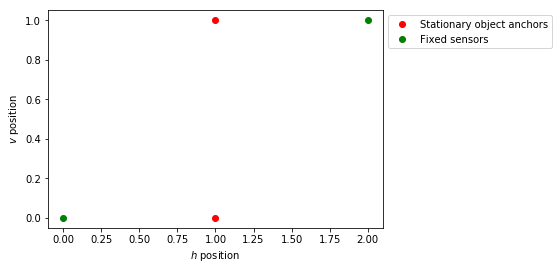

In [19]:
plt.plot(stationary_object_position_anchors[:,0],
         stationary_object_position_anchors[:,1],
         'ro',
        label='Stationary object anchors')
plt.plot(fixed_sensor_positions[:,0],
         fixed_sensor_positions[:,1],
         'go',
         label='Fixed sensors')
plt.xlabel('{} position'.format(dimension_names_long[0]))
plt.ylabel('{} position'.format(dimension_names_long[1]))
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Initial state

Define a function that generates samples of the initial state $\mathbf{X}_0$. We'll need this both to generate our simulated data and as an input to the particle filter. Moving objects are distributed uniformly throughout the room and the positions of the stationary objects are sampled from a 2-d Gaussian distribution centered on their anchors. We include some additional machinery to allow for the possibility of no moving objects or no stationary objects.

In [20]:
def x_initial_sample():
    if num_moving_objects > 0:
        moving_objects = np.random.uniform(high=np.tile(room_size,
                                                        num_moving_objects))
    else:
        moving_objects = np.array([])
    if num_stationary_objects > 0:
        stationary_objects = np.random.multivariate_normal(stationary_object_position_anchors.flatten(),
                                                           np.diagflat(np.repeat(stationary_object_position_error**2,
                                                                                 num_stationary_objects*num_dimensions)))
    else:
        stationary_objects = np.array([])
    return np.concatenate((moving_objects, stationary_objects))

Generate 1,000 samples and check that they have the properties we expect.

In [21]:
time_start = time.clock()
x_initial_samples = np.array([x_initial_sample() for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.254830824606


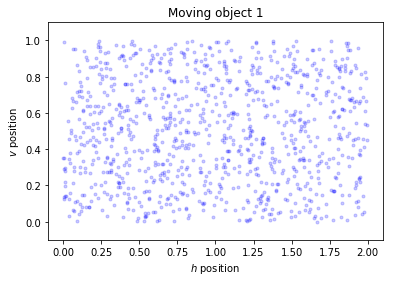

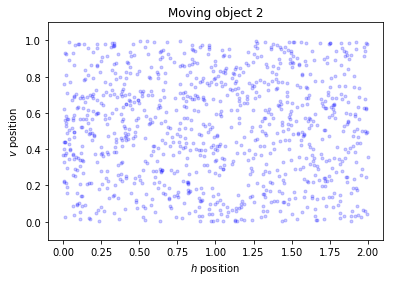

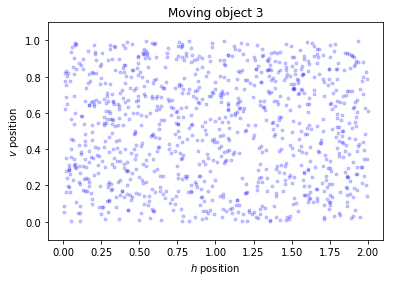

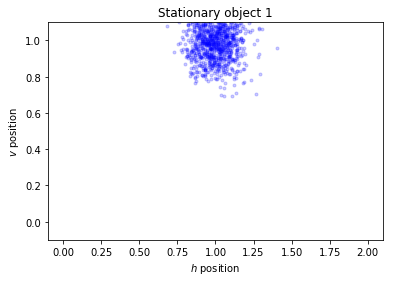

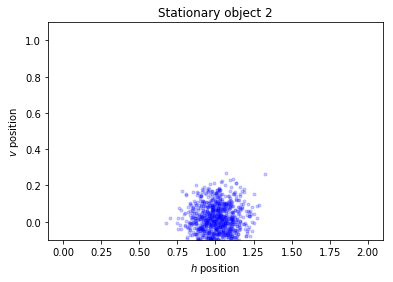

In [22]:
for object_index in range(num_objects):
    plt.plot(x_initial_samples[:,object_index*2],
             x_initial_samples[:,object_index*2 + 1], 'b.', alpha = 0.2)
    plt.title(object_names_long[object_index])
    plt.xlabel('{} position'.format(dimension_names_long[0]))
    plt.ylabel('{} position'.format(dimension_names_long[1]))
    plt.xlim(0 - stationary_object_position_error, room_size[0] + stationary_object_position_error)
    plt.ylim(0 - stationary_object_position_error, room_size[1] + stationary_object_position_error)
    plt.show()

Calculate the sample means of the initial positions.

In [23]:
np.mean(x_initial_samples, 0)

array([ 0.97088677,  0.49744485,  0.97507191,  0.5100823 ,  0.98847479,
        0.51007638,  0.99892648,  0.99261855,  1.00589145, -0.00431586])

Compare with the known means of the distributions the samples were drawn from (noting that the mean of the uniform distribution from zero to $a$ is $\frac{a}{2}$).

In [24]:
np.concatenate((np.tile(room_size/2, num_moving_objects),
                stationary_object_position_anchors.flatten()))

array([ 1. ,  0.5,  1. ,  0.5,  1. ,  0.5,  1. ,  1. ,  1. ,  0. ])

Calculate the sample standard deviations of the initial positions.

In [25]:
np.std(x_initial_samples, 0)

array([ 0.56609943,  0.28243537,  0.58611985,  0.28466416,  0.584226  ,
        0.28764518,  0.09917955,  0.10191519,  0.09942917,  0.0955627 ])

Compare with the known standard deviations of the distribution that the samples were drawn from (noting that the standard deviation of the uniform distribution over an interval of size $a$ is $\frac{a}{\sqrt{12}}$).

In [26]:
np.concatenate((np.tile(room_size/math.sqrt(12), num_moving_objects),
                np.repeat(stationary_object_position_error, num_stationary_objects*2)))

array([ 0.57735027,  0.28867513,  0.57735027,  0.28867513,  0.57735027,
        0.28867513,  0.1       ,  0.1       ,  0.1       ,  0.1       ])

### Transition model

Define a function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$. We'll use this both to generate our simulated data and as an input to the particle filter. Moving objects execute a simple 2-d random walk. Stationary objects generate two samples, one from their initial position distribution and one from a Gaussian centered on their last position, and then average these samples. The latter is a hack to introduce some jitter to the positions of the stationary objects while ensuring that they remain near their anchors. This jitter helps the particle filter converge.

In [27]:
def x_bar_x_prev_sample(x_prev):
    if num_moving_objects > 0:
        moving_object_positions = np.random.multivariate_normal(x_prev[:num_moving_objects*2],
                                                                np.diagflat(np.repeat(moving_object_drift**2,
                                                                                      num_moving_objects*num_dimensions)))
    else:
        moving_object_positions = np.array([])
    if num_stationary_objects > 0:
        jittered_positions = np.random.multivariate_normal(x_prev[num_moving_objects*2:],
                                                           np.diagflat(np.repeat(stationary_object_position_jitter**2,
                                                                                 num_stationary_objects*num_dimensions)))
        initial_positions = np.random.multivariate_normal(stationary_object_position_anchors.flatten(),
                                                          np.diagflat(np.repeat(stationary_object_position_error**2,
                                                                                num_stationary_objects*num_dimensions)))
        stationary_object_positions = (jittered_positions + initial_positions)/2
    else:
        stationary_object_positions = np.array([])
    return np.concatenate((moving_object_positions, stationary_object_positions))

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions.

In [28]:
test_x_value = x_initial_sample()

In [29]:
test_x_value

array([ 0.92410792,  0.48018433,  0.81239981,  0.6152298 ,  1.23094571,
        0.33059075,  0.97006302,  1.15951871,  1.04050881, -0.12010534])

Generate 1,000 samples (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [30]:
time_start = time.clock()
x_bar_x_prev_samples = np.array([x_bar_x_prev_sample(test_x_value) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.523975029771


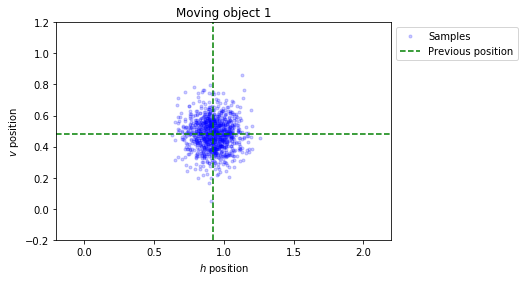

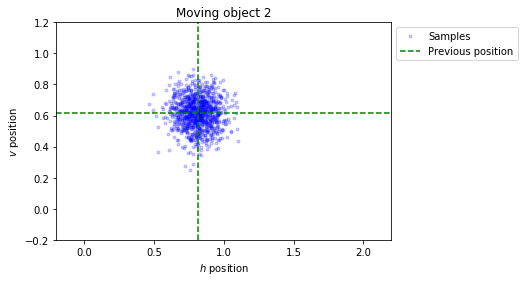

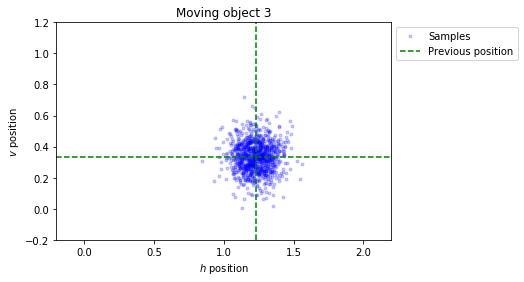

In [31]:
for object_index in range(num_moving_objects):
    plt.plot(x_bar_x_prev_samples[:,object_index*2],
             x_bar_x_prev_samples[:,object_index*2 + 1],
             'b.',
             alpha=0.2,
            label='Samples')
    plt.title(object_names_long[object_index])
    plt.xlabel('{} position'.format(dimension_names_long[0]))
    plt.ylabel('{} position'.format(dimension_names_long[1]))
    plt.axvline(x=test_x_value[object_index*2],
                linestyle='dashed',
                color='green',
                label='Previous position')
    plt.axhline(y=test_x_value[object_index*2 + 1], linestyle='dashed', color='green')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(0 - 2*stationary_object_position_error, room_size[0] + 2*stationary_object_position_error)
    plt.ylim(0 - 2*stationary_object_position_error, room_size[1] + 2*stationary_object_position_error)
    plt.show()

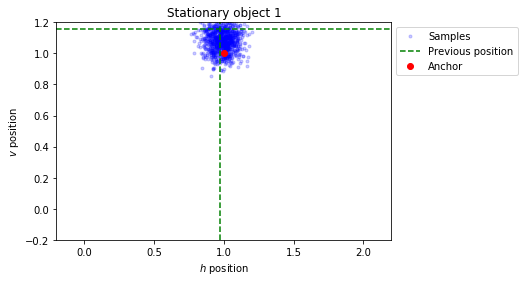

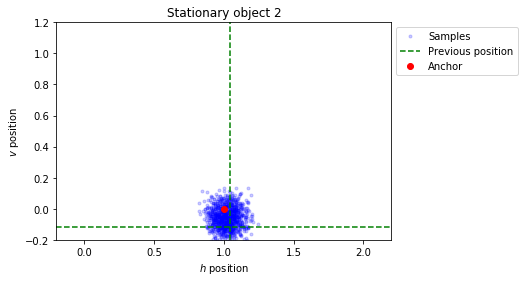

In [32]:
for object_index in range(num_moving_objects, num_objects):
    plt.plot(x_bar_x_prev_samples[:,object_index*2],
             x_bar_x_prev_samples[:,object_index*2 + 1],
             'b.',
             alpha=0.2,
             label='Samples')
    plt.title(object_names_long[object_index])
    plt.xlabel('{} position'.format(dimension_names_long[0]))
    plt.ylabel('{} position'.format(dimension_names_long[1]))
    plt.axvline(x=test_x_value[object_index*2], linestyle='dashed', color='green', label='Previous position')
    plt.axhline(y=test_x_value[object_index*2 + 1], linestyle='dashed', color='green')
    plt.plot(stationary_object_position_anchors[object_index-num_moving_objects][0],
            stationary_object_position_anchors[object_index-num_moving_objects][1],
            'ro',
            label = 'Anchor')
    plt.xlim(0 - 2*stationary_object_position_error, room_size[0] + 2*stationary_object_position_error)
    plt.ylim(0 - 2*stationary_object_position_error, room_size[1] + 2*stationary_object_position_error)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

### Sensor response model

Define a function that returns the distances between the different objects (in the same order as `y_names` above) given $\mathbf{X}$.

In [33]:
def distances_between_objects(x):
    return np.delete(np.linalg.norm(np.subtract(np.tile(x.reshape((num_objects, num_dimensions)),
                                                        (num_objects,1)),
                                                np.repeat(x.reshape((num_objects, num_dimensions)),
                                                          num_objects,
                                                          axis=0)),
                                    axis=1),
                     np.arange(num_objects)*num_objects + np.arange(num_objects))    

Define a function that returns the distances from the objects to the fixed sensors (in the same order as `y_names`) given $\mathbf{X}$.

In [34]:
def distances_to_fixed_sensors(x):
    if num_fixed_sensors > 0:
        return np.linalg.norm(np.subtract(np.repeat(x.reshape((num_objects, num_dimensions)), num_fixed_sensors, axis=0),
                                          np.tile(fixed_sensor_positions, (num_objects,1))),
                              axis=1)
    else:
        return np.array([])

Combine these two functions into a function that returns all of the measured distances (in the same order as `y_names`), given $\mathbf{X}$.

In [35]:
def distances(x):
    return np.concatenate((distances_between_objects(x), distances_to_fixed_sensors(x)))

Using this function, define the function that generates samples of the sensor readings $\mathbf{Y}$ given $\mathbf{X}$. We'll use this to generate our simulated data.

In [36]:
def y_bar_x_sample(x):
    return np.random.multivariate_normal(distances(x),
                                         np.diagflat(np.repeat(sensor_error**2, num_y_vars)))

Generate 1,000 samples (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [37]:
time_start = time.clock()
y_bar_x_samples = np.array([y_bar_x_sample(test_x_value) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.40703854633


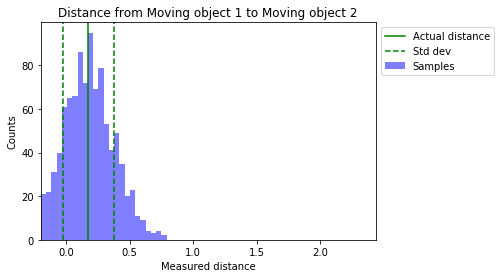

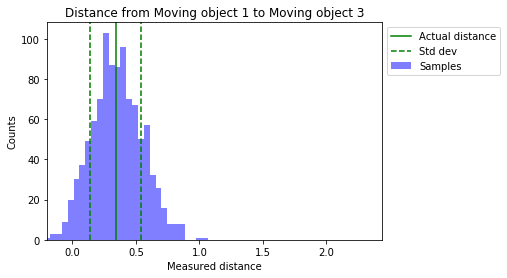

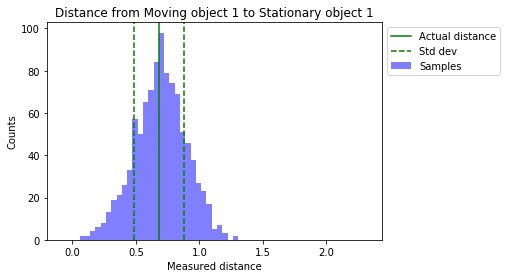

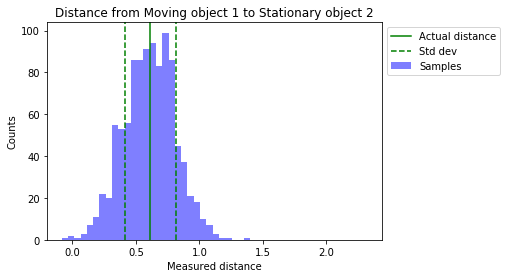

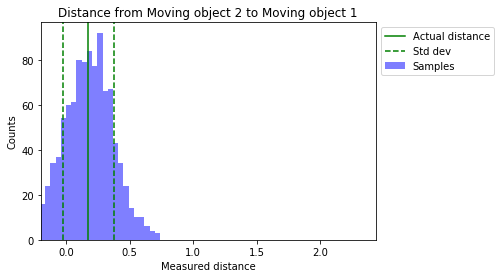

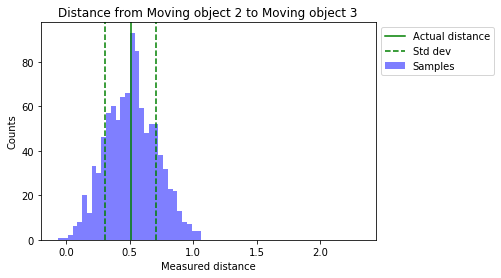

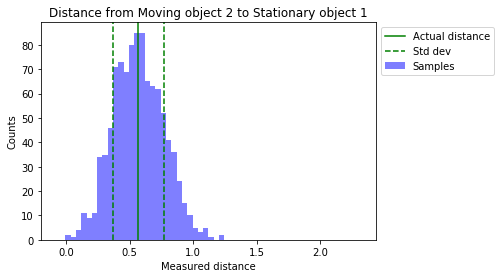

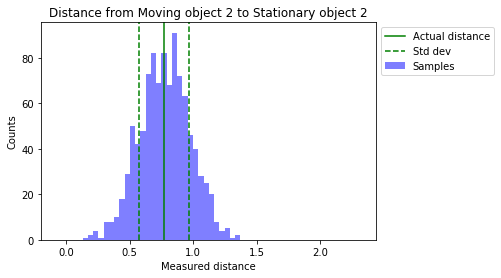

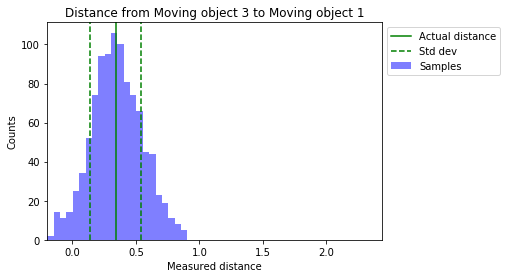

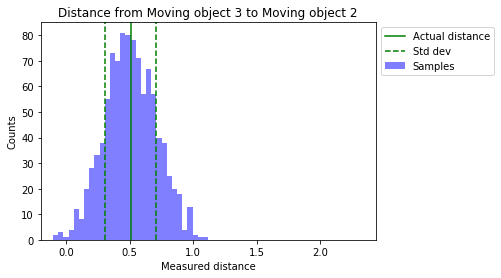

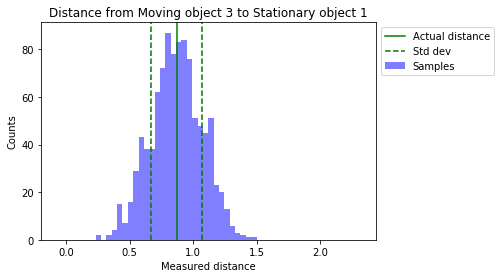

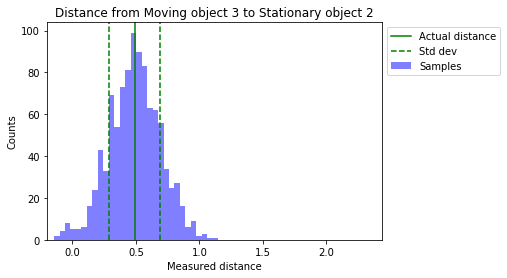

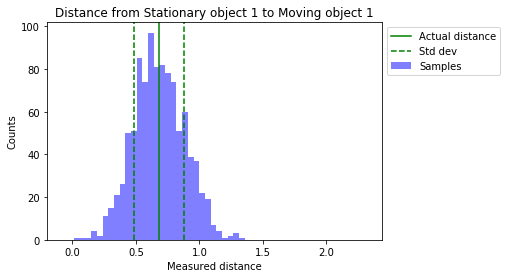

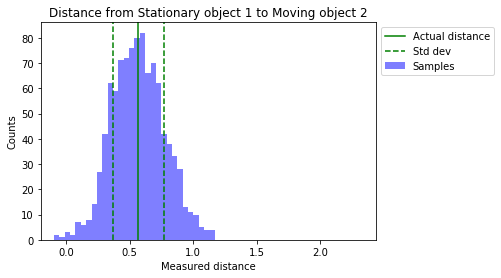

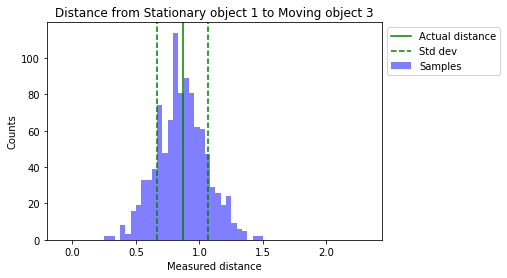

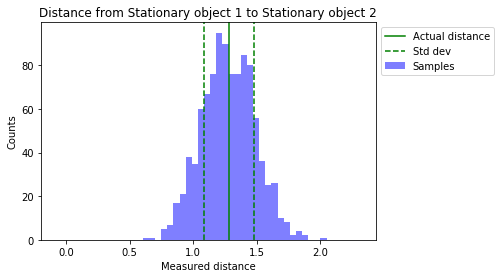

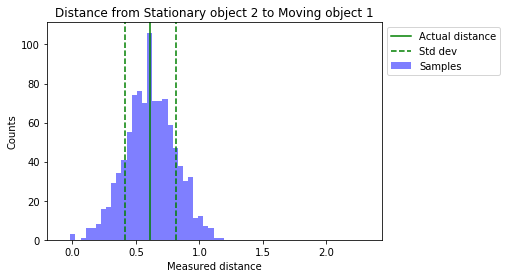

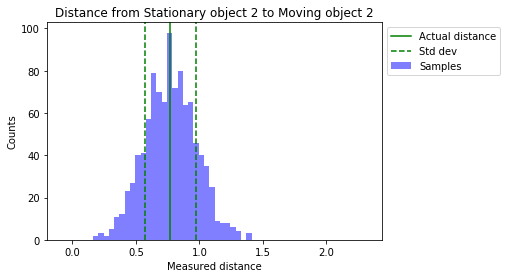

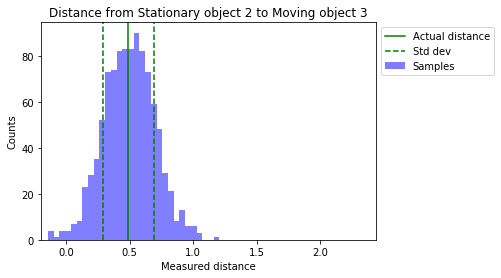

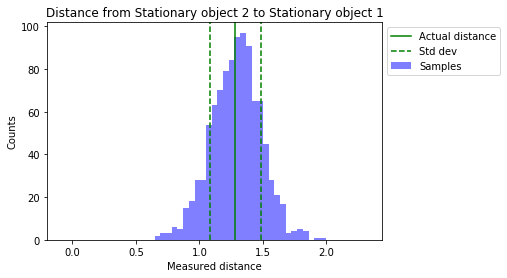

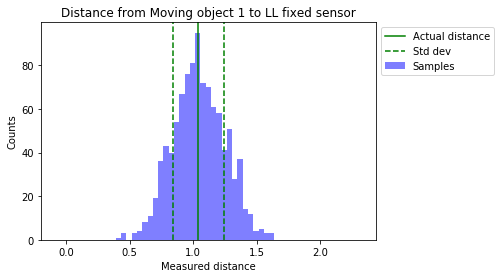

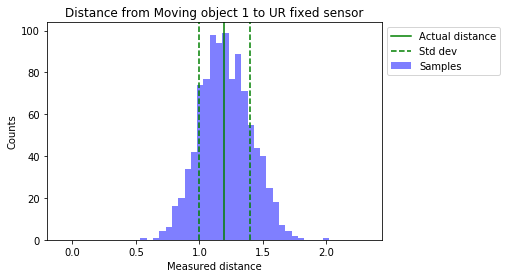

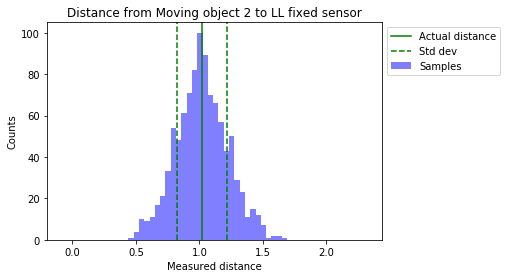

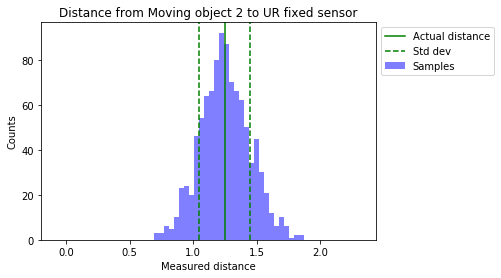

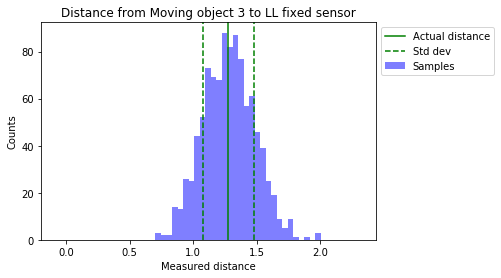

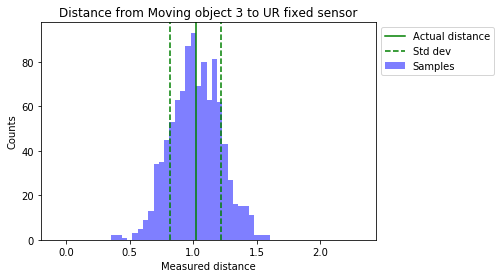

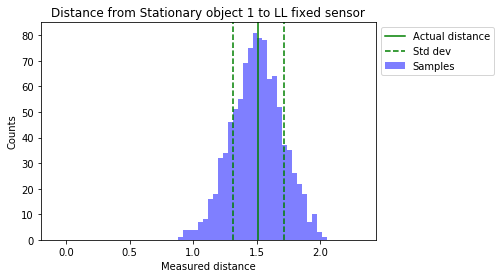

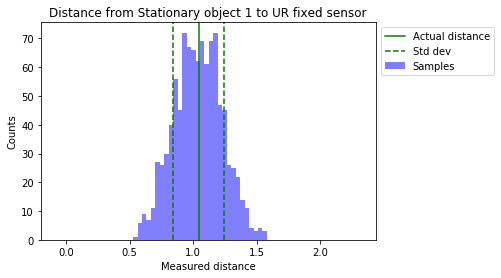

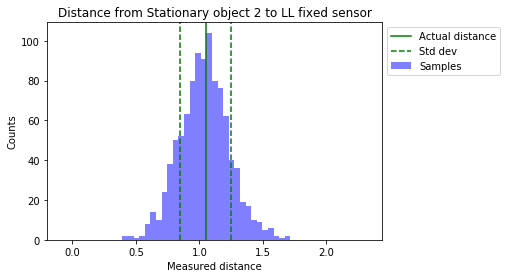

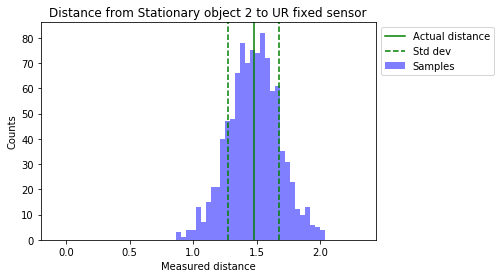

In [38]:
for y_var_index in range(num_y_vars):
    plt.hist(y_bar_x_samples[:,y_var_index], bins=30, facecolor='blue', alpha=0.5, label='Samples')
    plt.xlabel('Measured distance')
    plt.ylabel('Counts')
    plt.axvline(x=distances(test_x_value)[y_var_index], color='green', linestyle='solid', label = 'Actual distance')
    plt.axvline(x=distances(test_x_value)[y_var_index] - sensor_error, color='green', linestyle='dashed', label='Std dev')
    plt.axvline(x=distances(test_x_value)[y_var_index] + sensor_error, color='green', linestyle='dashed')
    plt.title(y_names_long[y_var_index])
    plt.xlim(0 - sensor_error, np.linalg.norm(room_size) + sensor_error)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Calculate the means of the samples.

In [39]:
np.mean(y_bar_x_samples, 0)

array([ 0.16666173,  0.35022195,  0.69194368,  0.60640728,  0.1751726 ,
        0.51548863,  0.56782295,  0.77558606,  0.34785435,  0.50902881,
        0.86719061,  0.49012277,  0.68238914,  0.56822801,  0.86078899,
        1.27603817,  0.61282651,  0.77203552,  0.49581907,  1.28772265,
        1.04500936,  1.20461111,  1.02054664,  1.25003355,  1.27950222,
        1.02156091,  1.50180192,  1.03766686,  1.03843532,  1.47789891])

Compare with the known distances for our test $\mathbf{X}$ value.

In [40]:
distances(test_x_value)

array([ 0.17525976,  0.34136149,  0.68088698,  0.61147105,  0.17525976,
        0.50616209,  0.56666402,  0.76990355,  0.34136149,  0.50616209,
        0.8690117 ,  0.48927823,  0.68088698,  0.56666402,  0.8690117 ,
        1.28156167,  0.61147105,  0.76990355,  0.48927823,  1.28156167,
        1.04141847,  1.19488581,  1.01906877,  1.24837587,  1.27456565,
        1.01958484,  1.51178898,  1.04221706,  1.04741771,  1.47487604])

Calculate the standard deviations of the samples.

In [41]:
np.std(y_bar_x_samples, 0)

array([ 0.20517159,  0.20073207,  0.20290928,  0.20177164,  0.19258373,
        0.19818235,  0.19697782,  0.19939304,  0.20224455,  0.20181377,
        0.20242406,  0.20182946,  0.20077395,  0.20654623,  0.19617186,
        0.20760289,  0.19494194,  0.2021907 ,  0.20019143,  0.19676259,
        0.20278386,  0.20018477,  0.20311278,  0.19586185,  0.20144912,
        0.19451859,  0.19982709,  0.18938169,  0.19631411,  0.19968027])

Compare with the defined sensor error.

In [42]:
sensor_error

0.2

Now we create the related function $f(\mathbf{Y} | \mathbf{X})$, which returns the probability density for a set of sensor readings, given the state of the system. We'll use this as an input to the particle filter. We start by defining a generic Gaussian probability density function. We work with log-probabilities rather than probabilities to prevent underflow problems. We construct the Gaussian distribution from base Python operations rather than use the `scipy` PDF function because the latter was meaningfully slower in our tests.

In [43]:
def log_pdf_gaussian(q, mean, sd):
    return -(q-mean)**2/(2*sd**2) - math.log(math.sqrt(2*math.pi)*sd)

For convenience, define a vectorized version of this function.

In [44]:
log_pdf_gaussian_vectorized = np.vectorize(log_pdf_gaussian)

Plot the generic Gaussian probability distibution function for an arbitrary mean and standard deviation to make sure it has the shape and normalization we expect.

In [45]:
q_range = np.arange(0.0, 10.0, 0.01)

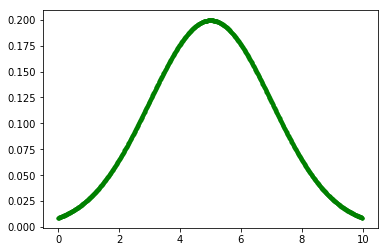

In [46]:
plt.plot(q_range, np.exp(log_pdf_gaussian_vectorized(q_range, 5.0, 2.0)), 'g.')
plt.show()

Using the generic Gaussian, define $\log(f(\mathbf{Y} | \mathbf{X}))$.

In [47]:
def log_f_y_bar_x(x, y):
    return np.sum(log_pdf_gaussian_vectorized(y, distances(x), sensor_error))

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect.

In [48]:
distance_range = np.arange(0, np.linalg.norm(room_size), np.linalg.norm(room_size)/500)

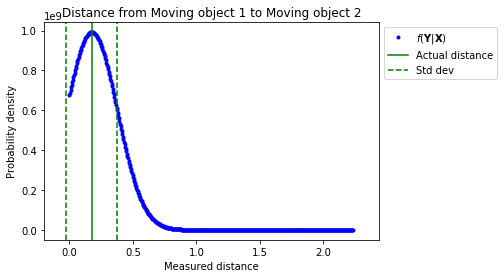

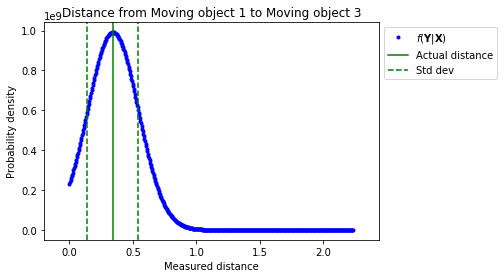

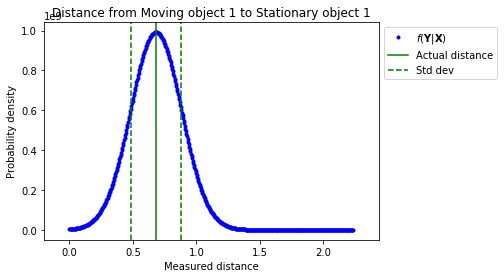

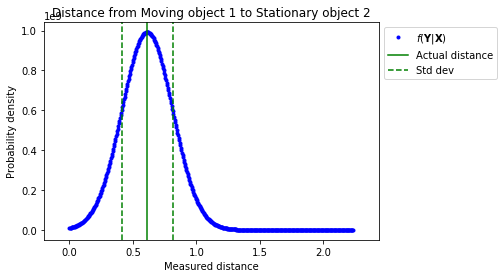

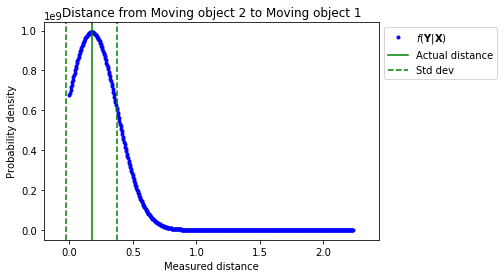

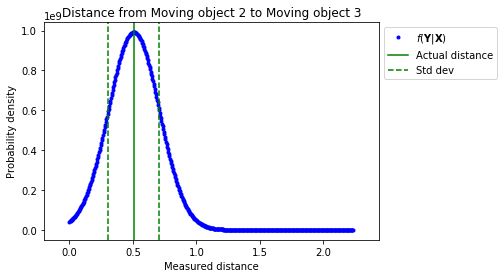

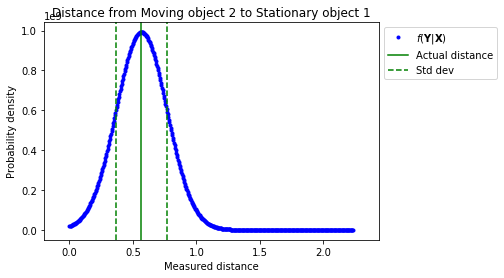

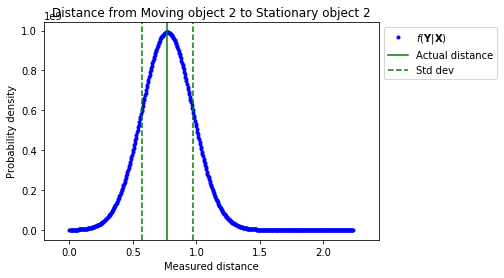

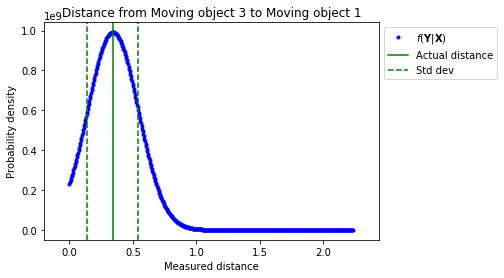

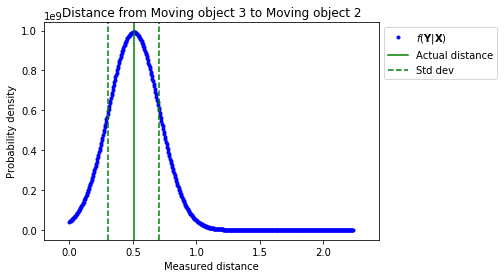

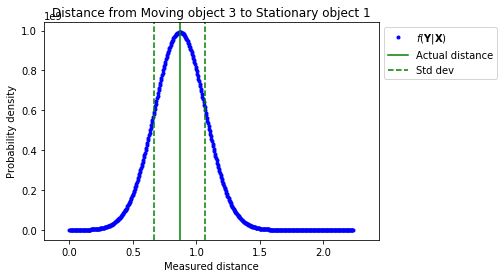

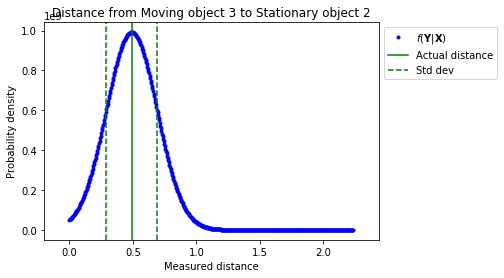

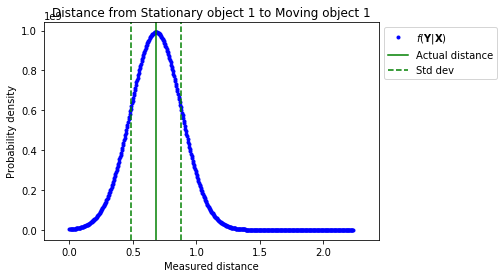

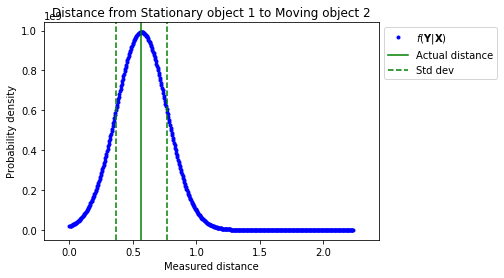

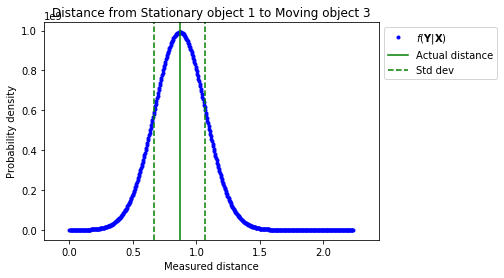

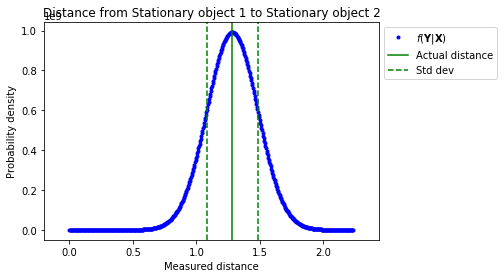

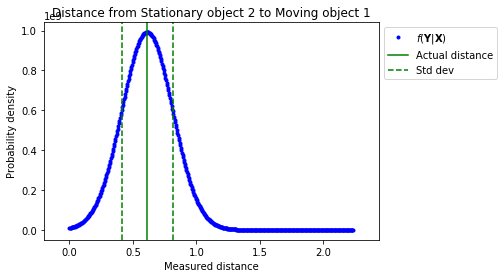

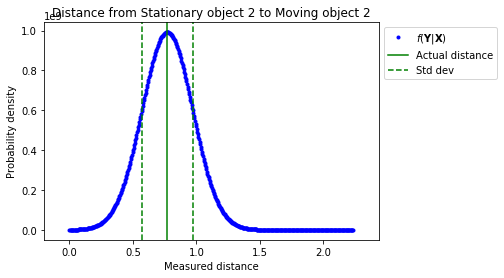

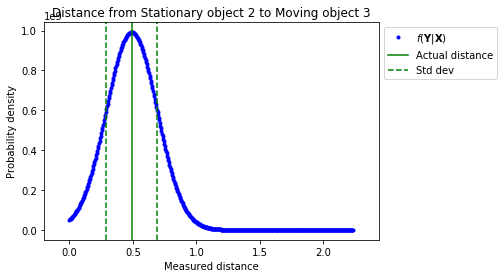

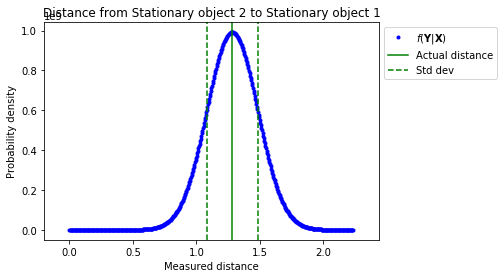

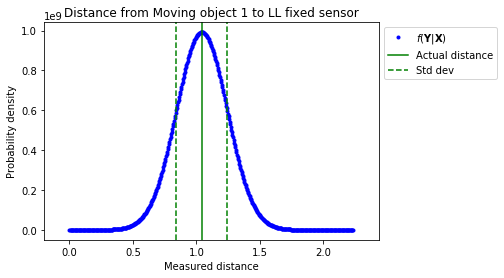

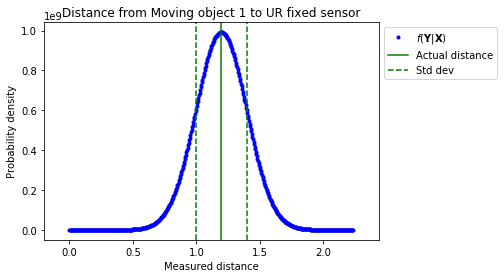

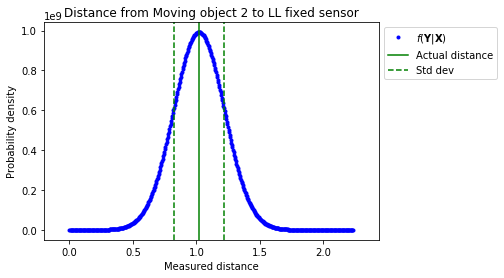

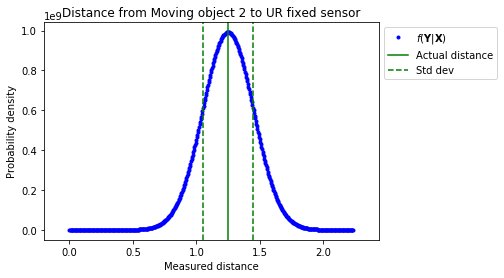

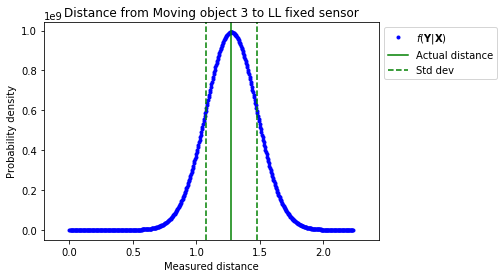

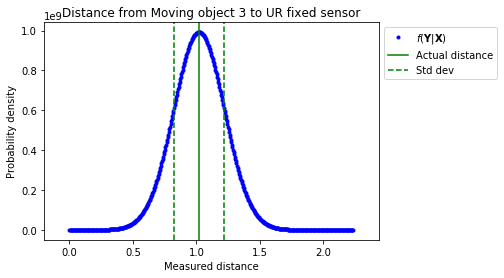

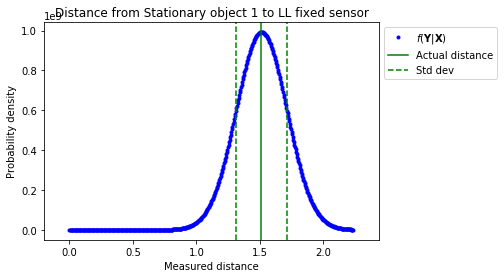

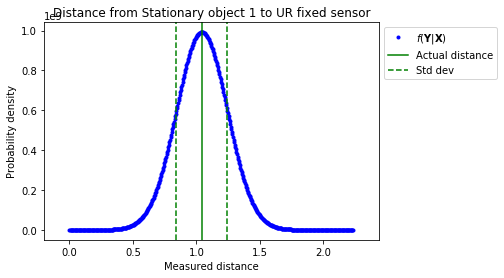

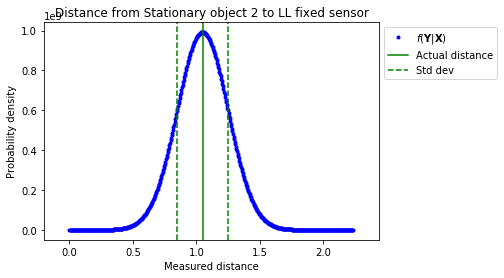

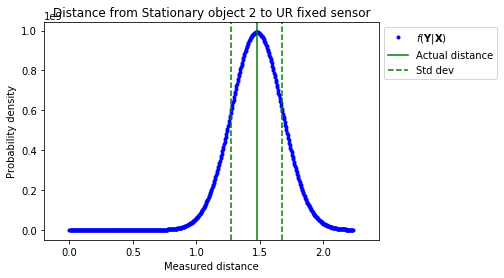

In [49]:
for y_var_index in range(num_y_vars):
    y_range = np.tile(distances(test_x_value), (len(distance_range), 1))
    y_range[:, y_var_index] = distance_range
    log_f_range = np.array([log_f_y_bar_x(test_x_value, y) for y in y_range])
    plt.plot(distance_range, np.exp(log_f_range), 'b.', label='$f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(x=distances(test_x_value)[y_var_index], color='green', linestyle='solid', label='Actual distance')
    plt.axvline(x=distances(test_x_value)[y_var_index] - sensor_error, color='green', linestyle='dashed', label='Std dev')
    plt.axvline(x=distances(test_x_value)[y_var_index] + sensor_error, color='green', linestyle='dashed')
    plt.title(y_names_long[y_var_index])
    plt.xlabel('Measured distance')
    plt.ylabel('Probability density')
    plt.xlim(0 -sensor_error, np.linalg.norm(room_size) + sensor_error)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()    

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Set the number of timesteps and initialize the variables.

In [50]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_t = np.zeros((num_timesteps, num_x_vars), dtype='float')
y_t = np.zeros((num_timesteps, num_y_vars), dtype='float')

Calculate the simulated data for $t=0$.

In [51]:
t[0] = 0.0

In [52]:
x_t[0] = x_initial_sample()

In [53]:
y_t[0] = y_bar_x_sample(x_t[0])

Calculate the simulated data for $t>0$.

In [54]:
timestep_size = 1.0

In [55]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_t[t_index] = x_bar_x_prev_sample(x_t[t_index - 1])
    y_t[t_index] = y_bar_x_sample(x_t[t_index])

Find the overall maximum and minimum $h$ and $v$ values across the entire simulation.

In [56]:
h_v_min_max = np.array([[np.min(x_t[:,range(0, num_x_vars, 2)]),
                         np.max(x_t[:,range(0, num_x_vars, 2)])],
                        [np.min(x_t[:,range(1, num_x_vars, 2)]),
                         np.max(x_t[:,range(1, num_x_vars, 2)])]])

Plot the positions of the objects to make sure they have the properties we expect.

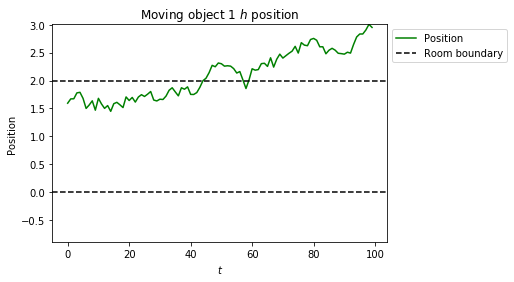

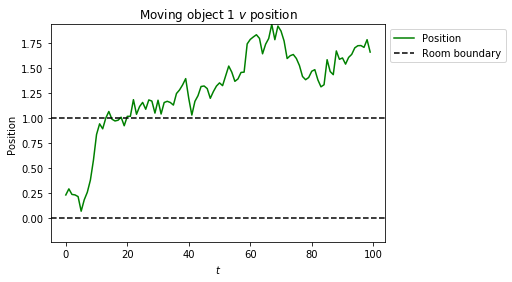

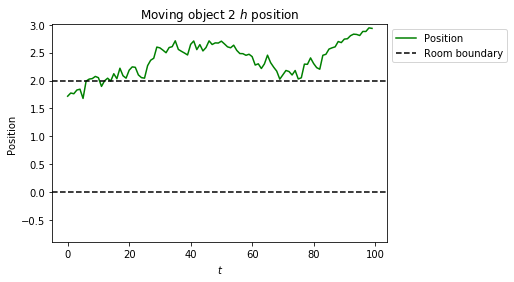

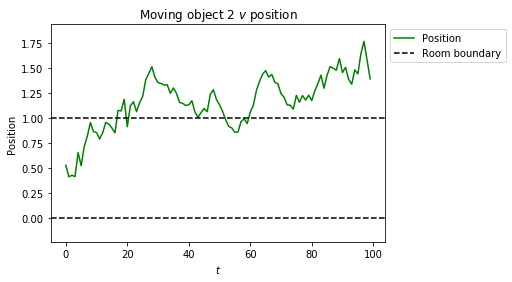

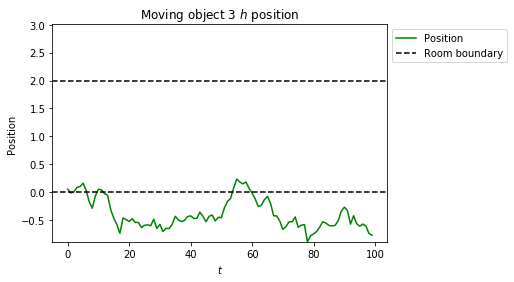

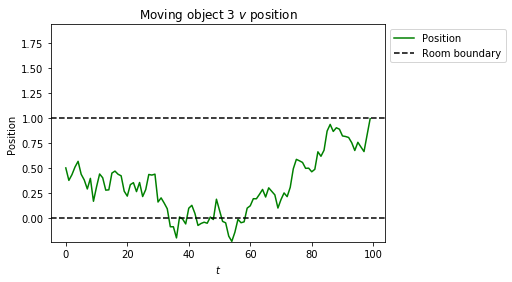

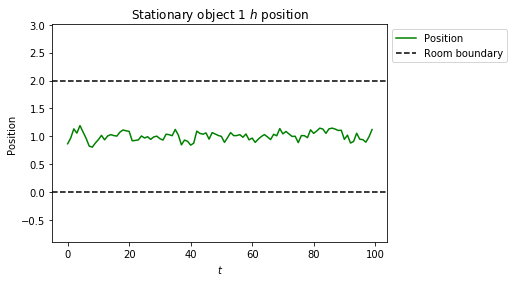

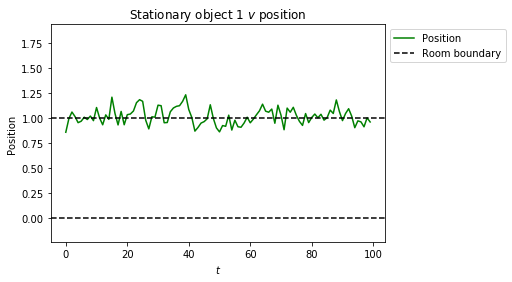

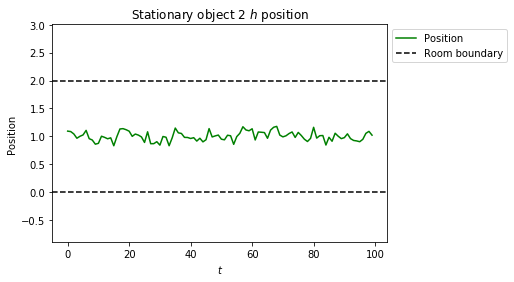

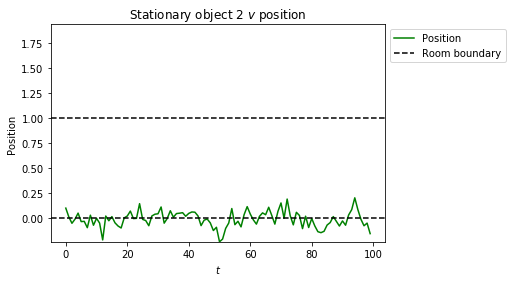

In [57]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:, x_var_index], 'g-', label='Position')
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.plot
    plt.xlabel('$t$')
    plt.ylabel('Position')
    plt.title(x_names_long[x_var_index])
    plt.ylim(np.min([0, h_v_min_max[x_var_index % 2, 0]]),
             np.max([room_size[x_var_index % 2], h_v_min_max[x_var_index % 2, 1]]))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot the sensor readings against the actual distances to the sensors, to make sure they have the properties we expect.

In [58]:
distances_t = np.array([distances(x) for x in x_t])

Calculate overall minimum and maximum distances generated in the simulation

In [59]:
distances_min = np.min(distances_t)

In [60]:
distances_max = np.max(distances_t)

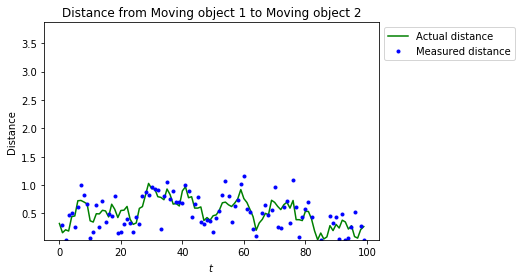

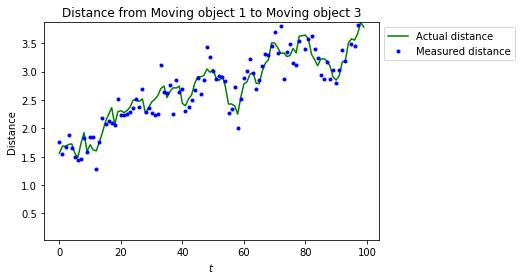

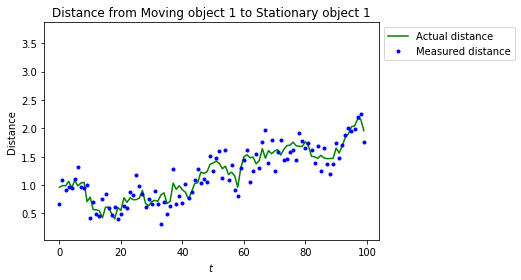

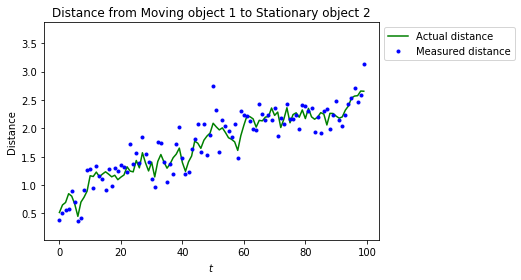

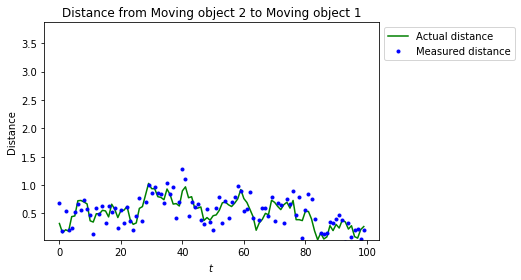

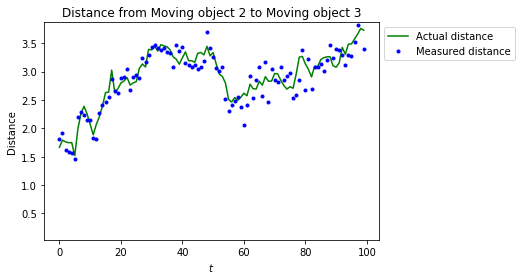

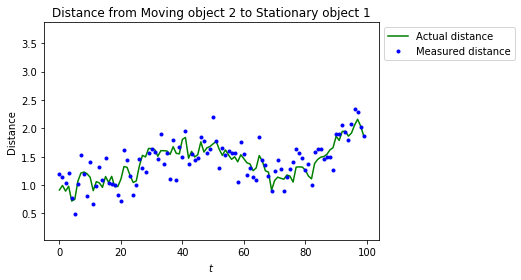

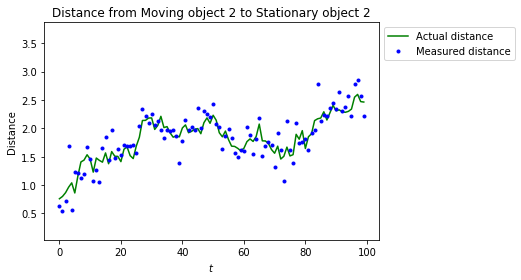

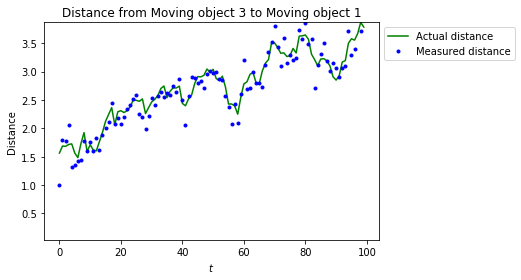

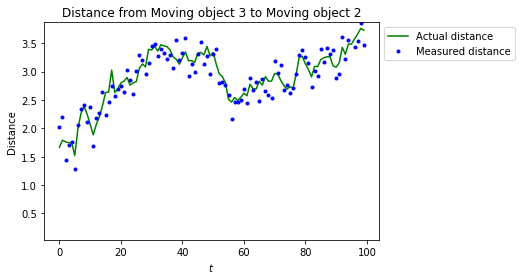

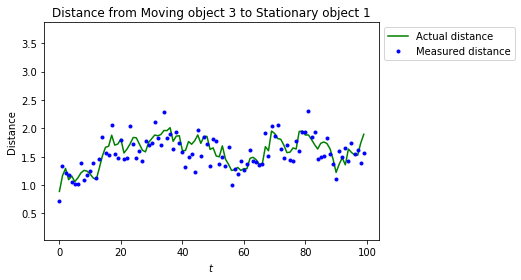

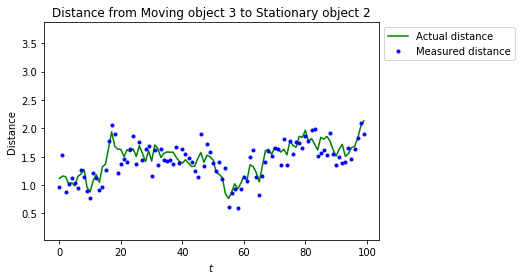

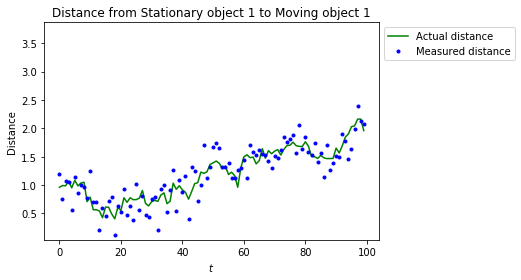

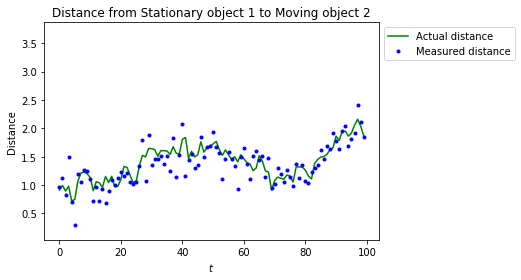

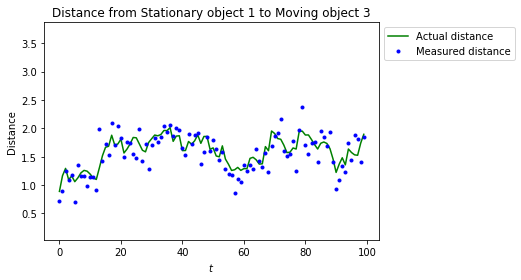

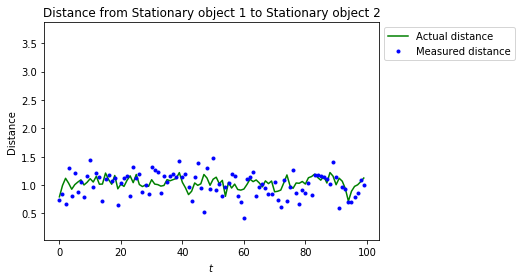

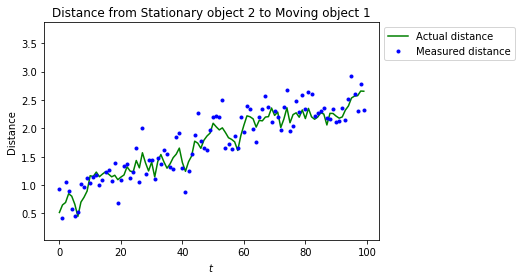

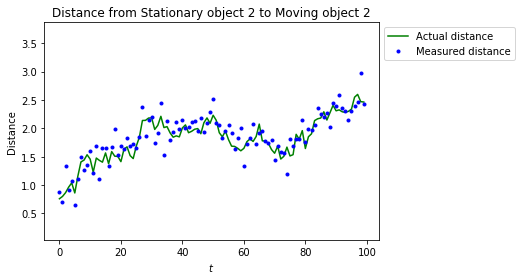

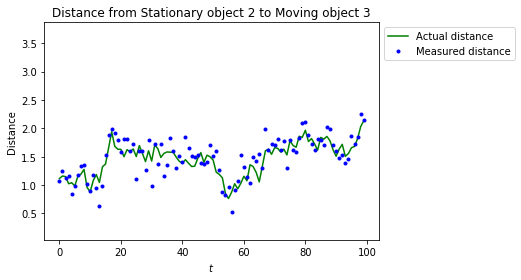

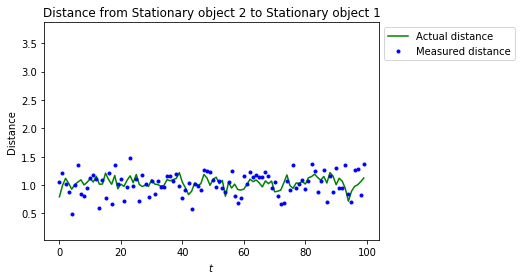

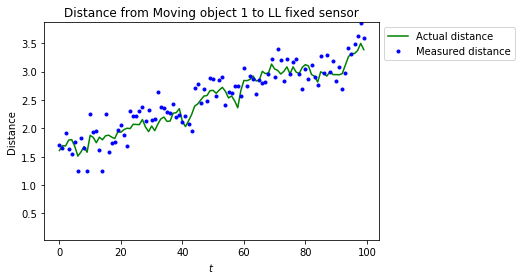

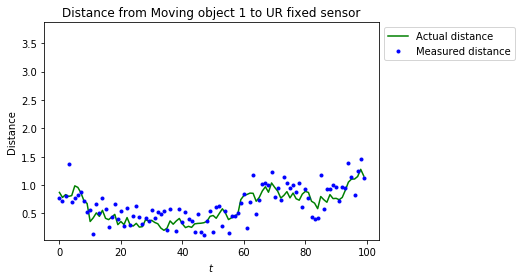

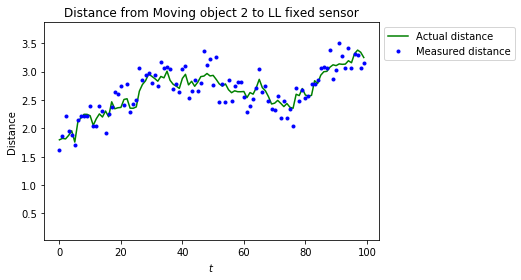

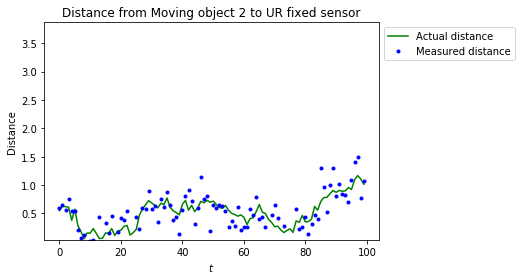

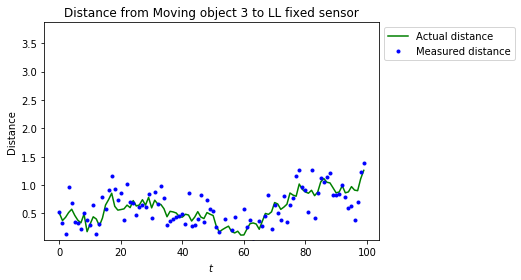

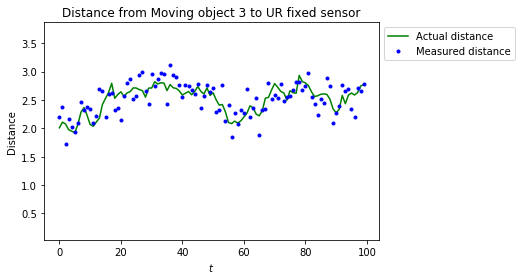

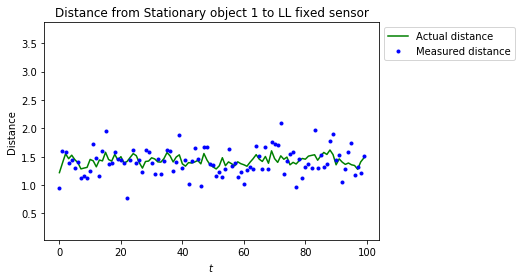

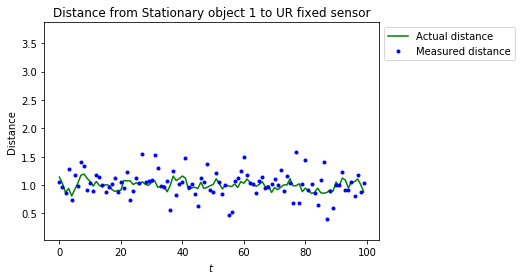

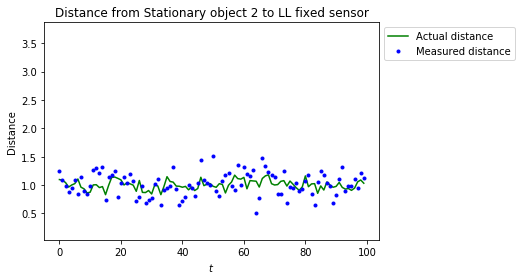

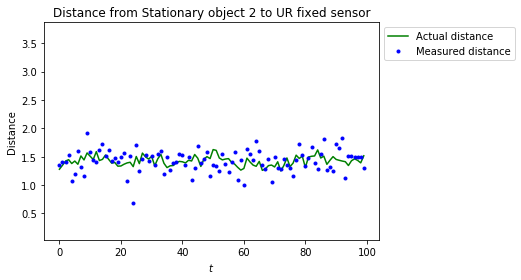

In [61]:
for y_var_index in range(num_y_vars):
    plt.plot(t, distances_t[:, y_var_index], 'g-', label='Actual distance')
    plt.plot(t, y_t[:, y_var_index], 'b.', label='Measured distance')
    plt.xlabel('$t$')
    plt.ylabel('Distance')
    plt.title(y_names_long[y_var_index])
    plt.ylim(distances_min, distances_max)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \mathbf{Y}_1, \ldots, \mathbf{Y}_t)$ using a particle filter

Set the number of particles and initialize variables.

In [62]:
num_particles = 500
particle_values = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
log_particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')
sampled_particle_indices = np.zeros((num_timesteps, num_particles), dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [63]:
time_start = time.clock()
for particle_index in range(num_particles):
    particle_values[0, particle_index] = x_initial_sample()
    log_particle_weights[0, particle_index] = log_f_y_bar_x(particle_values[0, particle_index], y_t[0])
log_particle_weights[0] = log_particle_weights[0] - misc.logsumexp(log_particle_weights[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.223972597772


Check to see that the particle weights are normalized.

In [64]:
math.exp(misc.logsumexp(log_particle_weights[0]))

0.9999999999999999

Calculate the weighted mean of the particles.

In [65]:
x_initial_mean = np.average(particle_values[0], axis=0, weights = np.exp(log_particle_weights[0]))

Plot the results.

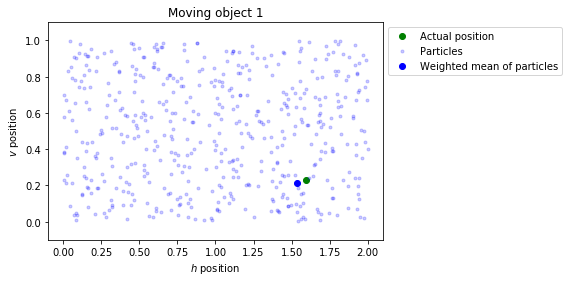

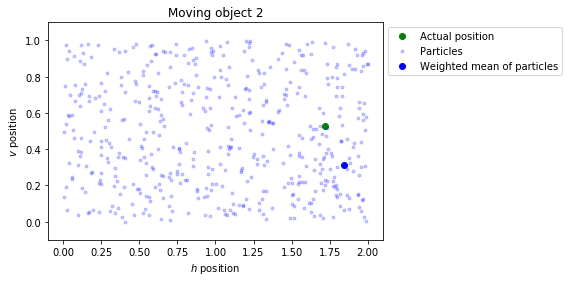

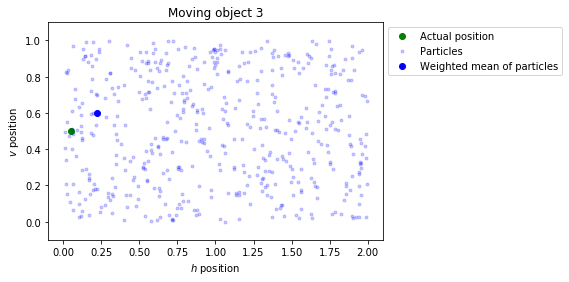

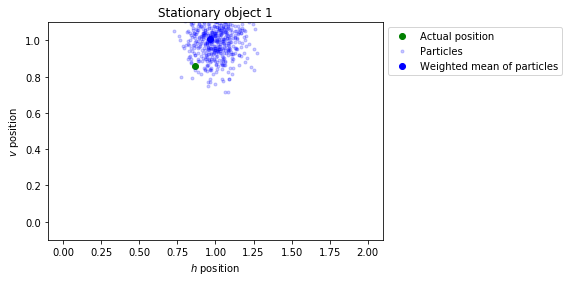

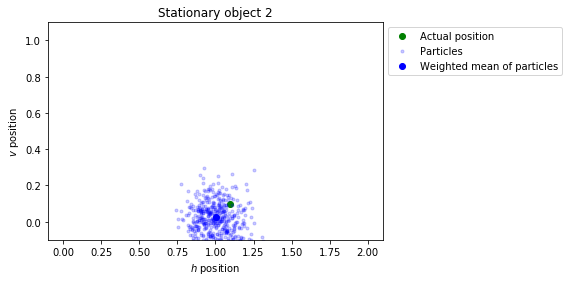

In [66]:
for object_index in range(num_objects):
    plt.plot(x_t[0,object_index*2],x_t[0,object_index*2 + 1],'go', label='Actual position')
    plt.plot(particle_values[0,:,object_index*2],particle_values[0,:,object_index*2 + 1], 'b.', alpha=0.2, label='Particles')
    plt.plot(x_initial_mean[object_index*2], x_initial_mean[object_index*2 + 1], 'bo', label='Weighted mean of particles')
    plt.title(object_names_long[object_index])
    plt.xlabel('{} position'.format(dimension_names_long[0]))
    plt.ylabel('{} position'.format(dimension_names_long[1]))
    plt.xlim(0 - stationary_object_position_error, room_size[0] + stationary_object_position_error)
    plt.ylim(0 - stationary_object_position_error, room_size[1] + stationary_object_position_error)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

This looks as we expect. For each object, the particles are distributed according to the initial probability distribution, not according to the actual position of the particle. The weighted means of the particles incorporate the sensor readings and therefore they are closer to the actual positions of the objects, but not precisely on top of them due to both sensor error and sampling error. The real test is whether the particles converge and track the actual state as we generate successive sets of particles.

Calculate the particles for all times $t>0$.

In [67]:
sys.stdout.write('t_index =')
sys.stdout.flush()
time_start = time.clock()
for t_index in range(1, num_timesteps):
    sys.stdout.write(' {}'.format(t_index))
    sys.stdout.flush()
    for particle_index in range(num_particles):
        sampled_particle_indices[t_index, particle_index] = np.random.choice(num_particles,
                                                                             p=np.exp(log_particle_weights[t_index - 1]))
        previous_particle = particle_values[t_index - 1,
                                            sampled_particle_indices[t_index, particle_index]]
#        print sampled_particle_indices[t_index, particle_index]
#        print previous_particle
        particle_values[t_index, particle_index] = x_bar_x_prev_sample(previous_particle)
        log_particle_weights[t_index, particle_index] = log_f_y_bar_x(particle_values[t_index, particle_index], y_t[t_index])
    log_particle_weights[t_index] = log_particle_weights[t_index]- misc.logsumexp(log_particle_weights[t_index])
print'\nTime elapsed = {}'.format(time.clock()-time_start)

t_index = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99
Time elapsed = 41.3589050202


Calculate and plot the maximum particle weight for each time step. If the maximum particle weight increases to 1.0 and stays there, then our particle filter has collapsed around a single value.

In [68]:
max_weights = np.max(np.exp(log_particle_weights), axis=1)

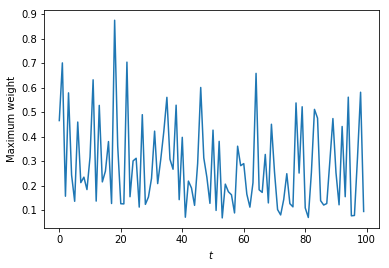

In [69]:
plt.plot(t, max_weights)
plt.xlabel('$t$')
plt.ylabel('Maximum weight')
plt.show()

Calculate and plot the number of particles actually sampled at each time step in the bootstrap process. If the number of particles actually sampled decreases to 1 and stays there, then our particle filter has collapsed around a single value.

In [70]:
num_sampled_particles = np.array([len(np.unique(sampled_particle_indices[t_index])) for t_index in range(num_timesteps)])

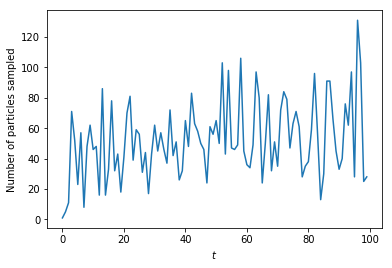

In [71]:
plt.plot(t, num_sampled_particles)
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()

Calculate the sample means and sample standard deviations of the particles at each time $t$.

In [72]:
x_mean_particle = np.average(
    particle_values, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), num_x_vars).reshape((num_timesteps, num_particles, num_x_vars))
)

In [73]:
x_squared_mean_particle = np.average(
    np.square(particle_values), 
    axis=1,
    weights=np.repeat(np.exp(log_particle_weights), num_x_vars).reshape((num_timesteps, num_particles, num_x_vars))
)

In [74]:
x_sd_particle = np.sqrt(np.abs(x_squared_mean_particle - np.square(x_mean_particle)))

Plot the sample means of the particles against the actual values of $\mathbf{X}_t$.

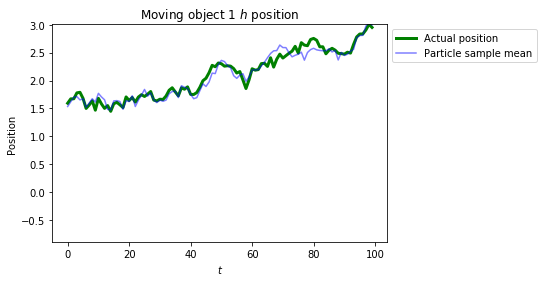

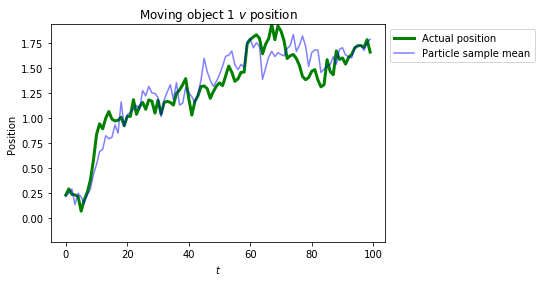

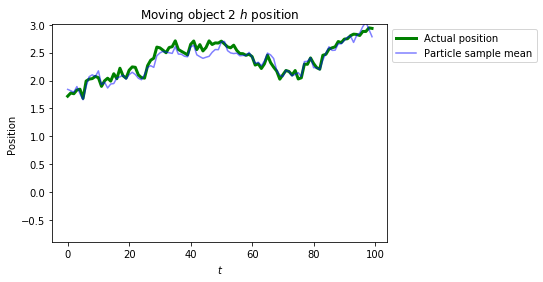

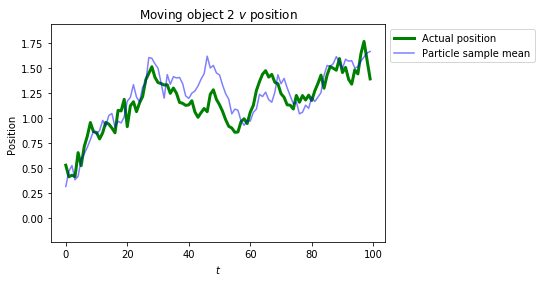

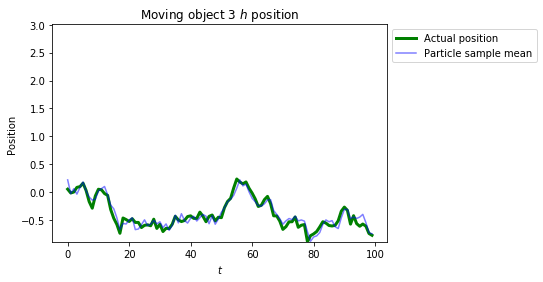

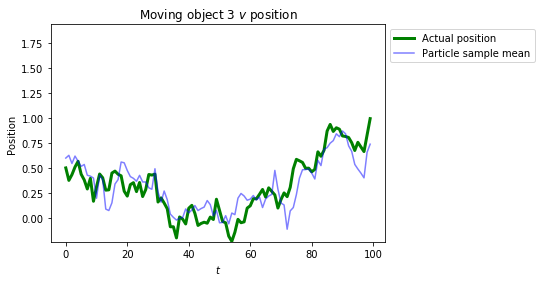

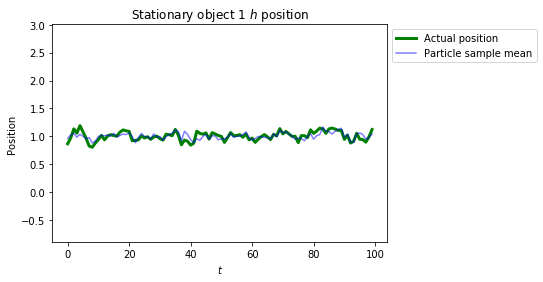

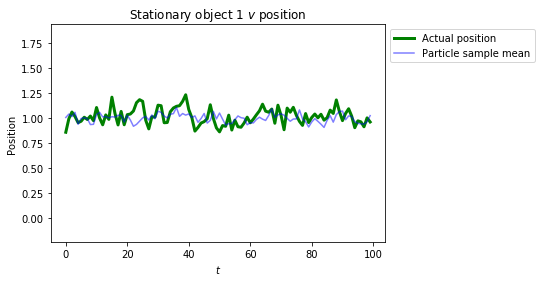

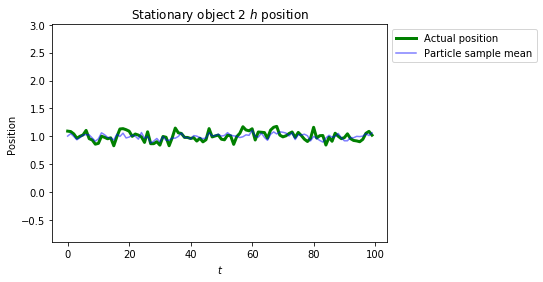

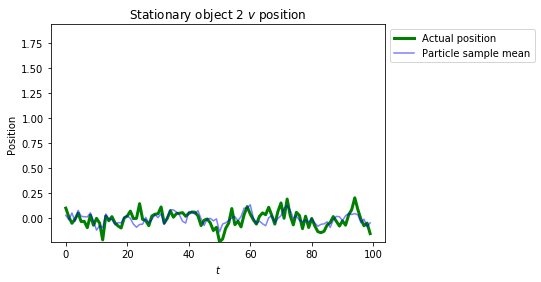

In [75]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.plot(t, x_mean_particle[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.xlabel('$t$')
    plt.ylabel('Position')
    plt.title(x_names_long[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.ylim(np.min([0, h_v_min_max[x_var_index % 2, 0]]),
             np.max([room_size[x_var_index % 2], h_v_min_max[x_var_index % 2, 1]]))
    plt.show()

Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

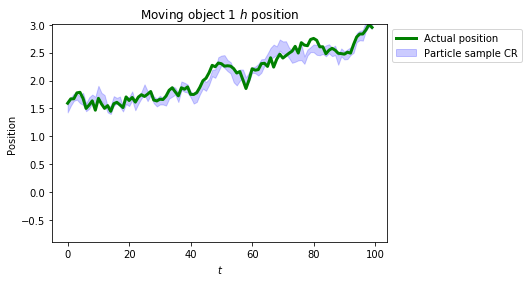

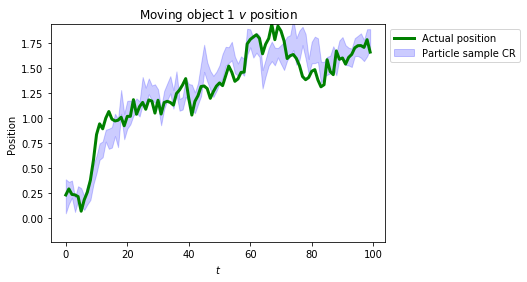

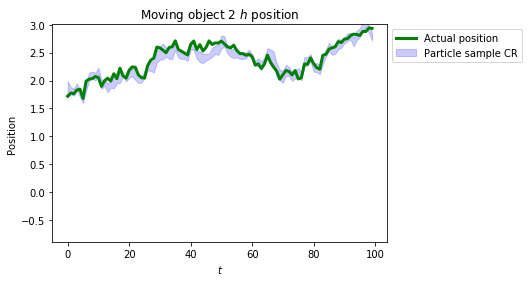

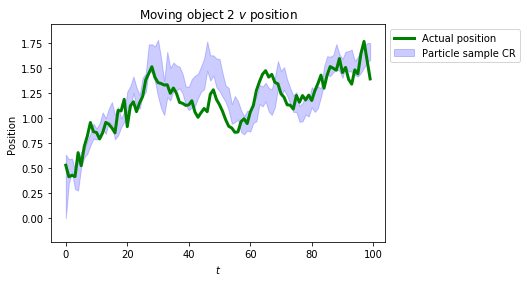

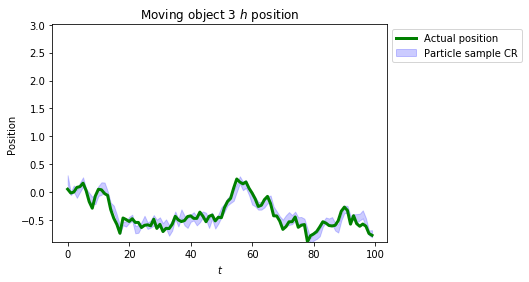

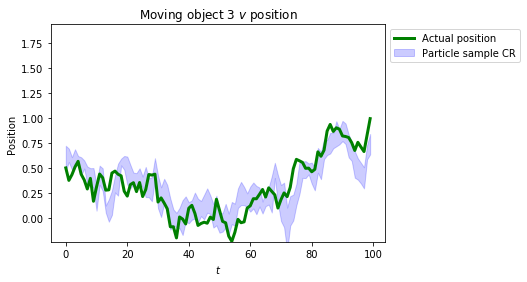

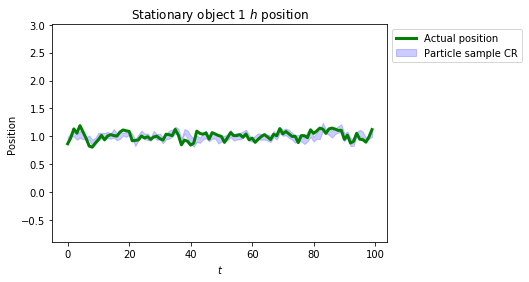

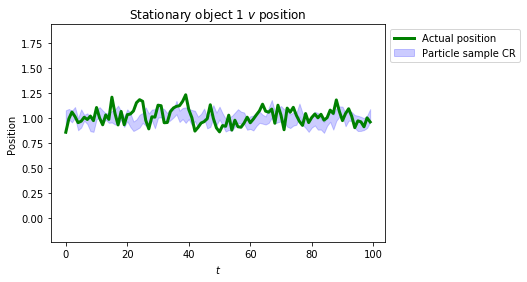

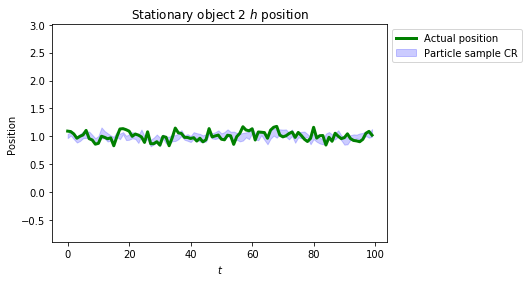

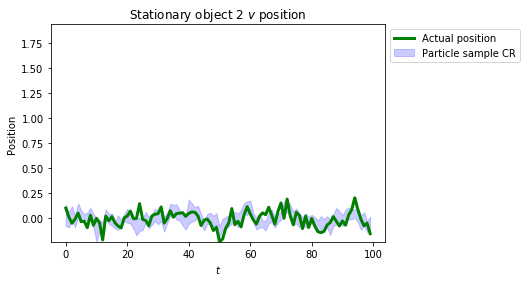

In [76]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.fill_between(
        t,
        x_mean_particle[:,x_var_index] - x_sd_particle[:, x_var_index],
        x_mean_particle[:,x_var_index] + x_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.xlabel('$t$')
    plt.ylabel('Position')
    plt.title(x_names_long[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.ylim(np.min([0, h_v_min_max[x_var_index % 2, 0]]),
             np.max([room_size[x_var_index % 2], h_v_min_max[x_var_index % 2, 1]]))
    plt.show()